# Algorithme de Grover 

Formation donnée par le Laboratoire d'algorithmique quantique (AlgoLab),le 3 novembre 2025.

L’Équipe de Placement SPOT
514.552.9512 | support@placementspot.ca

Le travail pratique devra être complété avant le 5 novembre 23h55. Le lien du travail sera actif à partir de 20h00.
Lien vers le travail pratique: https://forms.office.com/r/Ts2iJiwe2V.

Un programme d'été rémuné de 16 semaines : https://xanadu.applytojob.com/apply/7KwBLR1cnC/Xanadu-Residency-Program-2026.

Voir [PennyLane Discussion Forum](https://discuss.pennylane.ai/).

Voir [GitHub](https://github.com/algolab-quantique/IMACA-CMAI-Grover) and [Colab](https://github.com/algolab-quantique/IMACA-CMAI-Grover).

Voir également [IBM Quantum Composer](https://quantum.cloud.ibm.com/composer) et 
[Bloch sphere simulator](https://bloch.kherb.io/).


## Algorithme de Grover

- L'algorithme de Grover est un algorithme de recherche quantique dans une liste non structurée de $N$ éléments, utilisant seulement $O(\sqrt{N})$
- Accélération quadratique.
- [The Story of Shor's Algorithm, Straight From the Source | Peter Shor](https://www.youtube.com/watch?v=6qD9XElTpCE).

## Une fonction à satisfaire

Une recherche dans une **liste non-ordonnée** est analogue à une fonction qui prend un **entier** en entrée et qui retourne ...

$$f(x) = \begin{cases} 0 & \text{pour la plupart des entrées} \\ 1 & \text{pour } x = x^\star \end{cases}$$

On cherche pour quelle(s) **entrée(s)** la fonction retourne

$$f(x^\star) = 1 \qquad x^\star = ?$$

Exemple : $f_{774-2159}(x)$


## Les habitants de la planète Pincus*

### La problématique

Les voyageurs qui ont séjourné sur la planète Pincus ont observé que tous ses habitants qui sont en **santé** sont **bruyants**, sauf s'ils sont **peureux**. Ceux qui sont **peureux** et **discrets** sont **heureux**, tout comme ceux qui sont en **santé** et **bruyants**. Les habitant **heureux** et **discrets** sont en **santé**, mais ceux qui sont **peureux** et en **santé** sont **tristes**. Finalement, même si les habitants **tristes** et **malades** sont toujours **apeurés**, les **peureux** et **bruyants** sont en **santé**.

😱 Peureux / Courageux  
😃 Heureux / Triste  
🤢 Malade / En santé  
🥳 Bruyant / Discret

Que peut-ton conclure à propos des habitants de la planète Pincus?

*Scénario tirée et adapté de The Art of Computer Programming, Volume 4, Donald E. Knuth

## Importer les bibliothèques nécessaires

In [52]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import XGate, ZGate

import os, sys
sys.path.append(os.getcwd())
print(sys.executable)

/Users/alain/Workspace/GitHub/quantum-computing/.venv/bin/python


In [53]:
# Import the utils functions from the repository
# from utils import get_disjunction_control_state, get_disjunction_qubits

def variable_name_to_int(var_name):
    """This function returns an integer associated with a given variable

    Args:
        var_name (str): the current variable. For example : x1.

    Returns:
        int: an integer associated with the variable name. For example :0.
    """
    if var_name == "x0":
        return 0
    if var_name == "x1":
        return 1
    if var_name == "x2":
        return 2
    if var_name == "x3":
        return 3
    return -1


def get_variable_list_from_clause(disj_clause):
    """This function returns a list of integers associated with the variables in a given disjunction clause

    Args:
        disj_clause (dict): the current disjunction clause. For example : {'x0' : False, 'x3' : True, 'x1' : True}.

    Returns:
        list: a list of integers associated with the variables in disj_clause. For example : [0, 3, 1].
    """
    variables = []
    for var_name in disj_clause:
        variables.append(variable_name_to_int(var_name=var_name))
    return variables


def get_disjunction_qubits(disj_clause, clause_qubit, var_qubits):
    """This function returns the right qubits to which you want to apply the disjunction clause.

    For example, if we are looking at the first clause, we would have the following parameters :

        -   disj_clause = {'x2' : True, 'x0' : True, 'x3' : True}.
        -   clause_qubit = 0. The first clause is reprensented by the index 0 and the last one (seventh), by 6.
        -   var_qubits = qubits associated with variables x2, x0 and x3

        and we would return :

        -   disjunction_qubits = [x2, x0, x3, c4]. A list of qubits representing variables x2, x0 and x3 and clause 0.

    Args:
        circuit (QuantumCircuit): the oracle circuit from which we get the right qubits
        disj_clause (dict): the current disjunction clause
        ancillar_id (int): variable that represents the ID of current clause

    Returns:
        list: Returns a list of the qubits that are involved in the disjunction clause
    """
    variables = get_variable_list_from_clause(disj_clause)

    disjunction_qubits = []

    for var in variables:
        disjunction_qubits.append(var_qubits[var])

    disjunction_qubits.append(clause_qubit)

    return disjunction_qubits


def get_disjunction_control_state(disj_clause):
    """This function returns the control state of the multi controlled x-gate according to a disjunction clause.

    Args:
        disj_clause (dict): the current disjunction clause. For example : {'x1' : False, 'x4' : True, 'x2' : True}.

    Returns:
        str : Returns a string containing the control state. For example : '001'. (Little endian notation)
    """
    ctrl_state = ""
    # Get the control state according to given clause
    for var_name in disj_clause:
        state = disj_clause[var_name]
        if state:
            ctrl_state = "0" + ctrl_state
        else:
            ctrl_state = "1" + ctrl_state
    return ctrl_state


## Un peu de logique - Opérateurs logiques

**La conjonction** ($x$ **et** $y$) : $x \land y$ est vrai si $x$ est vrai **et** $y$ est vrai

**La disjonction** ($x$ **ou** $y$) : $x \lor y$ est vrai si $x$ est vrai **ou** $y$ est vrai

**La négation** (**non** $x$) : $\neg x$ est vrai si $x$ est faux (aussi noté $\bar{x}$)

| $x$ | $y$ | $x \land y$ | $x \lor y$ |
|-----|-----|-------------|------------|
| F   | F   | F           | F          |
| V   | F   | F           | V          |
| F   | V   | F           | V          |
| V   | V   | V           | V          |

Étant donné que...

| $x$ | $\bar{x}$ |
|-----|-----------|
| F   | V         |
| V   | F         |


## Un peu de logique - Formule logique et satisfiabilité

Une **proposition** est une composition de **variables logiques** à l'aide de **conjonctions**, de **disjonctions** et de **négations**.

$$f = (x \land \bar{y}) \land (\bar{x} \lor z)$$

On dit qu'elle est **satisfiable** si on peut **attribuer des valeurs** (vrai/faux) de sorte que la formule s'**évalue à vrai**.

| $x$ | $y$ | $z$ | $x \land \bar{y}$ | $\bar{x} \lor z$ | $f$ |
|-----|-----|-----|-------------------|------------------|-----|
| F   | F   | F   | F                 | V                | F   |
| V   | F   | F   | V                 | F                | F   |
| F   | V   | F   | F                 | V                | F   |
| V   | V   | F   | F                 | F                | F   |
| F   | F   | V   | F                 | V                | F   |
| V   | F   | V   | V                 | V                | V   |
| F   | V   | V   | F                 | V                | F   |
| V   | V   | V   | F                 | V                | F   |


## Un peu de logique - Loi de De Morgan

On peut convertir une **conjonction** (et) en **disjonction** (ou) avec la relation de **De Morgan**.

$$f = x \land y = \neg(\bar{x} \lor \bar{y})$$

Par exemple, supposons que les variables logiques suivantes décrive un objet:
- Cet objet est un **fruit** ($x$ est vrai);
- Cet objet est **jaune** ($y$ est vrai);
- Cet objet est **une banane** ($f$ est vrai). 🍌

La relation de De Morgan nous dit que :  
Si un objet n'est **pas un fruit** *ou* n'est **pas jaune**, ce n'est **pas une banane**.


## Un peu de logique - Loi de De Morgan

On peut convertir une **conjonction** (et) en **disjonction** (ou) avec la relation de **De Morgan**.

$$f = x \land y = \neg(\bar{x} \lor \bar{y})$$

| $x$ | $y$ | $x \land y$ |
|-----|-----|-------------|
| F   | F   | F           |
| V   | F   | F           |
| F   | V   | F           |
| V   | V   | V           |

On peut vérifier la relation de De Morgan avec la table de vérité suivante:

| $\bar{x}$ | $\bar{y}$ | $\bar{x} \lor \bar{y}$ | $\neg(\bar{x} \lor \bar{y})$ |
|-----------|-----------|------------------------|------------------------------|
| V         | V         | V                      | F                            |
| F         | V         | V                      | F                            |
| V         | F         | V                      | F                            |
| F         | F         | F                      | V                            |


## Un peu de logique - Proposition conditionnelle

Une **proposition conditionnelle**

$$x \rightarrow y$$

| $x$ | $y$ |
|-----|-----|
| F   | ?   |
| V   | V   |

implique que si $x$ est **vrai**, $y$ l'est aussi. Si $x$ est **faux**, on ne sait rien sur $y$.

Par exemple, supposons que les variables logiques décrivent
- Sam a **mangé** une **banane** ($x$ est vrai)  
- Sam a **mangé** un **fruit** ($y$ est vrai) 🍌

Si Sam a **mangé** une **banane**, il a donc **mangé** un **fruit**. Si Sam **n'a pas mangé** une **banane**, on ne peut **pas conclure** s'il a mangé un fruit ou non.


## Un peu de logique - Règle d'inférence

La **règle d'inférence** permet de traduire une **proposition conditionnelle** en une **disjonction** qui sera **vrai** si la **proposition conditionnelle** est **respectée**.

$$x \rightarrow y \longrightarrow \bar{x} \lor y$$

| $x$ | $y$ | $x \rightarrow y$ | $\bar{x} \lor y$ |
|-----|-----|-------------------|------------------|
| F   | F   | ✅                | V                |
| V   | F   | ❌                | F                |
| F   | V   | ✅                | V                |
| V   | V   | ✅                | V                |



## Les habitants de la planète Pincus - Les variables logiques

|     |        | Vrai (1) | Faux (0)   |
|-----|--------|----------|------------|
| 😱  | $x_0$  | Peureux  | Courageux  |
| 😃  | $x_1$  | Heureux  | Triste     |
| 🤢  | $x_2$  | Malade   | En santé   |
| 🥳  | $x_3$  | Bruyant  | Discret    |


## Les habitants de la planète Pincus - Les propositions

...les habitants qui sont en **santé** sont **bruyants**, sauf s'ils sont **peureux**

Si un habitant en **santé** est **courageux**, il sera **bruyant**.

$$\bar{x}_2 \land \bar{x}_0 \rightarrow x_3$$

|           | Vrai      | Faux      |
|-----------|-----------|-----------|
| 😱 $x_0$  | Peureux   | Courageux |
| 😃 $x_1$  | Heureux   | Triste    |
| 🤢 $x_2$  | Malade    | En santé  |
| 🥳 $x_3$  | Bruyant   | Discret   |



## Les habitants de la planète Pincus - Conversion d'une proposition conditionnel en conjonction

On utilise d'abord la **règle d'inférence**

$$\bar{x}_2 \land \bar{x}_0 \rightarrow x_3 \longrightarrow \neg(\bar{x}_2 \land \bar{x}_0) \lor x_3$$

$$x \rightarrow y \equiv \bar{x} \lor y$$

Ensuite, la **règle de De Morgan**

$$\neg(\bar{x}_2 \land \bar{x}_0) \lor x_3 = x_0 \lor x_2 \lor x_3$$

$$\neg(\bar{x} \land \bar{y}) = x \lor y$$

Finalement, on combine les deux pour obtenir notre règle de conversion

$$\bar{x}_2 \land \bar{x}_0 \rightarrow x_3 = x_0 \lor x_2 \lor x_3$$

$$x \land y \rightarrow z = \bar{x} \lor \bar{y} \lor z$$

# Les sept clauses du problème de Pincus

Une clause de la forme $(x_0 \lor x_2 \lor \neg x_3)$ est écrite : 
```python
clause = {'x0' : True, 'x2' : True, 'x3' : False}
````

Rappel : 

* x0 = Peureux
* x1 = Heureux
* x2 = Malade
* x3 = Bruyant


## Explication plus détaillée de la construction de la clause 1

**Énoncé original** : "Tous les habitants en santé sont bruyants, sauf s'ils sont peureux"

**Étape 1 : Reformulation logique**

Cette phrase signifie :
- **Si** un habitant est en santé **ET** non peureux, **alors** il est bruyant

En logique : $(¬x_2 \land ¬x_0) \rightarrow x_3$

Où :
- $¬x_2$ = en santé (car x2 = Malade)
- $¬x_0$ = non peureux (car x0 = Peureux)
- $x_3$ = bruyant

**Étape 2 : Conversion en clause (forme CNF)**

Pour convertir une implication $A \rightarrow B$ en clause, on utilise l'équivalence :
$$A \rightarrow B \equiv ¬A \lor B$$

Donc :
$$(¬x_2 \land ¬x_0) \rightarrow x_3$$

devient :

$$¬(¬x_2 \land ¬x_0) \lor x_3$$

En appliquant la loi de De Morgan $¬(A \land B) = ¬A \lor ¬B$ :

$$¬¬x_2 \lor ¬¬x_0 \lor x_3$$

Ce qui simplifie à :

$$x_2 \lor x_0 \lor x_3$$

**Étape 3 : Traduction en notation Python**

La clause $(x_2 \lor x_0 \lor x_3)$ signifie : "x2 OU x0 OU x3"

En notation Python :
```python
clause1 = {'x0': True, 'x2': True, 'x3': True}
```

Tous les littéraux sont positifs (True) car ils apparaissent sans négation dans la clause finale.

## Les sept clauses du problème de Pincus

Une clause de la forme

$$
(x_0 \lor x_2 \lor \neg x_3)
$$

est écrite : 
```python
clause = {'x0': True, 'x2': True, 'x3': False}
```

**Rappel des variables :**
* x0 = Peureux
* x1 = Heureux
* x2 = Malade
* x3 = Bruyant



## Les habitants de la planète Pincus - Les propositions

$$x \land y \rightarrow z \longrightarrow \bar{x} \lor \bar{y} \lor z$$

| Proposition | Forme conditionnelle | Forme disjonctive |
|-------------|----------------------|-------------------|
| Si un habitant en **santé** est **courageux**, il est aussi **bruyant**. | $\bar{x}_2 \land \bar{x}_0 \rightarrow x_3$ | $x_2 \lor x_0 \lor x_3$ |
| Si un habitant est **peureux** et **discret**, il est aussi **heureux**. | $x_0 \land \bar{x}_3 \rightarrow x_1$ | $\bar{x}_0 \lor x_3 \lor x_1$ |
| Si un habitant est en **santé** et **bruyant**, il est aussi **heureux**. | $\bar{x}_2 \land x_3 \rightarrow x_1$ | $x_2 \lor \bar{x}_3 \lor x_1$ |
| Si un habitant est en **heureux** et **discret**, il est aussi en **santé**. | $x_1 \land \bar{x}_3 \rightarrow \bar{x}_2$ | $\bar{x}_1 \lor x_3 \lor \bar{x}_2$ |
| Si un habitant est en **peureux** et en **santé**, il est aussi **triste**. | $x_0 \land \bar{x}_2 \rightarrow \bar{x}_1$ | $\bar{x}_0 \lor x_2 \lor \bar{x}_1$ |
| Si un habitant est en **triste** et **malade**, il est aussi **peureux**. | $\bar{x}_1 \land x_2 \rightarrow x_0$ | $x_1 \lor \bar{x}_2 \lor x_0$ |
| Si un habitant est en **peureux** et **bruyant**, il est aussi en **santé**. | $x_0 \land x_3 \rightarrow \bar{x}_2$ | $\bar{x}_0 \lor \bar{x}_3 \lor \bar{x}_2$ |


In [ ]:
clauses = []

# Si un habitant est en santé et courageux, il est aussi bruyant. 
# (x2 ⌵ x0 ⌵ x3)  
clauses.append({'x2' : True, 'x0' : True, 'x3' : True})

# Si un habitant est peureux et discret, il est aussi heureux.
# (¬x0 ⌵ x3 ⌵ x1)  
# écrire la définition de la clause ici
clauses.append({'x0': False, 'x3': True, 'x1': True})

# Si un habitant est en santé et bruyant, il est aussi heureux.
# (x2 ⌵ ¬x3 ⌵ x1)  
# écrire la définition de la clause ici
clauses.append({'x2': True, 'x3': False, 'x1': True})

# Si un habitant est en heureux et discret, il est aussi en santé.
# (¬x1 ⌵ x3 ⌵ ¬x2)  
# écrire la définition de la clause ici
clauses.append({'x1': False, 'x3': True, 'x2': False})

# Si un habitant est en peureux et en santé, il est aussi triste.
# (¬x0 ⌵ x2 ⌵ ¬x1)  
# écrire la définition de la clause ici
clauses.append({'x0': False, 'x2': True, 'x1': False})

# Si un habitant est en triste et malade, il est aussi peureux.
# (x1 ⌵ ¬x2 ⌵ x0)  
# écrire la définition de la clause ici
clauses.append({'x0': True, 'x2': False, 'x1': True})

# Si un habitant est en peureux et bruyant, il est aussi en santé.
# (¬x0 ⌵ ¬x3 ⌵ ¬x2)  
# écrire la définition de la clause ici
clauses.append({'x0': False, 'x3': False, 'x2': False})

# La proposition principale

On peut alors assembler la **proposition principale** du problème

$$
f(x_0, x_1, x_2, x_3) =
(x_2 \lor x_0 \lor x_3) \land (\bar{x}_0 \lor x_3 \lor x_1) \land (x_2 \lor \bar{x}_3 \lor x_1) \land (\bar{x}_1 \lor x_3 \lor \bar{x}_2) \land (\bar{x}_0 \lor x_2 \lor \bar{x}_1) \land (x_1 \lor \bar{x}_2 \lor x_0) \land (\bar{x}_0 \lor \bar{x}_3 \lor \bar{x}_2)
$$

On pourra déduire comment sont les habitants de la planètes Pincus, si on trouve une **combinaison des variables logiques** de sorte que cette **formule s'évalue à Vrai**.

|     |     | **Vrai** | **Faux** |
|:---:|:---:|:--------:|:--------:|
| 😱  | x₀  | Peureux  | Courageux |
| 😃  | x₁  | Heureux  | Triste |
| 🤢  | x₂  | Malade   | En santé |
| 🥳  | x₃  | Bruyant  | Discret |

## Problème de satisfiabilité - Les propositions

On cherche à savoir s'il existe une configuration qui satisfait la formule logique

$$
f(\stackrel{?}{x_0}, \stackrel{?}{x_1}, \stackrel{?}{x_2}, \stackrel{?}{x_3}) = 1
$$

$$
f(x_0, x_1, x_2, x_3) = (x_2 \lor x_0 \lor x_3) \land (\bar{x}_0 \lor x_3 \lor x_1) \land (x_1 \lor \bar{x}_3 \lor x_2) \land (\bar{x}_1 \lor x_3 \lor \bar{x}_2) \land (\bar{x}_0 \lor x_2 \lor \bar{x}_1) \land (x_1 \lor \bar{x}_2 \lor x_0) \land (\bar{x}_0 \lor \bar{x}_3 \lor \bar{x}_2)
$$

Par exemple,

$$
f(0, 0, 0, 0) = (0 \lor 0 \lor 0) \land (1 \lor 0 \lor 0) \land (0 \lor 1 \lor 0) \land (1 \lor 0 \lor 1) \land (1 \lor 0 \lor 1) \land (0 \lor 1 \lor 0) \land (1 \lor 1 \lor 1) = 0
$$

$$
f(1, 1, 1, 1) = (1 \lor 1 \lor 1) \land (0 \lor 1 \lor 1) \land (1 \lor 0 \lor 1) \land (0 \lor 1 \lor 0) \land (0 \lor 1 \lor 0) \land (1 \lor 0 \lor 1) \land (0 \lor 0 \lor 0) = 0
$$

Nous avons $2^4 = 16$ combinaisons possibles à tester pour les variables logiques $(x_0, x_1, x_2, x_3)$.

# Encodage dans les qubits

On attribut un **qubit** à chaque **variable logique**

$$
f(x_0, x_1, x_2, x_3) \qquad\qquad |x_3x_2x_1x_0\rangle
$$

On résume ces variables sous la forme d'un **vecteur** de composantes binaires ou d'un **état de base**

$$
\mathbf{x} = (x_0, x_1, x_2, x_3) \qquad\qquad |\mathbf{x}\rangle = |x_3x_2x_1x_0\rangle
$$

L'évaluation de la **proposition principale** se résume à

$$
f(\mathbf{x})
$$

## Algorithme de Grover

**Oracle** : Marque les états en inversant leur phase.

**Diffuseur** : Amplifie les probabilités pour les états dont la phase est inversée.



## Algorithme de Grover - L'état de superposition uniforme

Une **porte Hadamard** sur un qubit permet de préparer une **superposition**

$$\hat{H}\ket{0} = \frac{\ket{0} + \ket{1}}{\sqrt{2}} = \ket{+}$$

Des **portes Hadamard** sur plusieurs qubits permettent de préparer l'**état de superposition uniforme**

$$\ket{+} \otimes \ket{+} \otimes \ket{+} = \frac{\ket{0} + \ket{1}}{\sqrt{2}} \otimes \frac{\ket{0} + \ket{1}}{\sqrt{2}} \otimes \frac{\ket{0} + \ket{1}}{\sqrt{2}}$$

$$= \frac{1}{\sqrt{2^3}} (\ket{000} + \ket{001} + \ket{010} + \ket{011} + \ket{100} + \ket{101} + \ket{110} + \ket{111})$$



## Algorithme de Grover - L'état de superposition uniforme

Pour un système de $n$ qubits, l'état de superposition uniforme est

$$\ket{s} = \frac{1}{\sqrt{2^n}} \sum_{\mathbf{x}} \ket{\mathbf{x}}$$

et comporte toutes les $2^n$ **possibilités**.


## Algorithme de Grover - The *good* and the *bad* states

Pour un système de $n$ qubits, l'état de superposition uniforme est

$$|s\rangle = \frac{1}{\sqrt{2^n}} \sum_{\mathbf{x}} |\mathbf{x}\rangle$$

Parmi ces états, certains **satisfont** la proposition principale $f$ (the *good*), alors que les autres **ne la satisfont pas** (the *bad*)

$$|s\rangle = \frac{1}{\sqrt{2^n}} \left(\sum_{\mathbf{x} \in B} |\mathbf{x}\rangle + \sum_{\mathbf{x} \in G} |\mathbf{x}\rangle\right)$$

## Algorithme de Grover - The *good* and the *bad* states

On peut donc écrire l'état de superposition uniforme comme une combinaison de **deux états**

$$\ket{s} = \cos(\theta/2)\ket{b} + \sin(\theta/2)\ket{g}$$

avec les états

$$\cos(\theta/2)\ket{b} = \frac{1}{\sqrt{2^n}} \sum_{\mathbf{x} \in B} \ket{\mathbf{x}}$$

$$\sin(\theta/2)\ket{g} = \frac{1}{\sqrt{2^n}} \sum_{\mathbf{x} \in G} \ket{\mathbf{x}}$$


## Algorithme de Grover - Principe de fonctionnement

**TODO** : Importer les images de la présentation

$$\ket{s} = \cos(\theta/2)\ket{b} + \sin(\theta/2)\ket{g}$$

$$\ket{\psi_0} = \cos(\theta/2)\ket{b} + \sin(\theta/2)\ket{g}$$

$$p_g = \sin^2(\theta/2)$$


$$\ket{\psi'_0} = \cos(\theta/2)\ket{b} - \sin(\theta/2)\ket{g}$$

$$p_g = \sin^2(\theta/2)$$


$$\ket{\psi_1} = \cos(3\theta/2)\ket{b} + \sin(3\theta/2)\ket{g}$$

$$p_g = \sin^2(3\theta/2)$$


$$\ket{\psi'_1} = \cos(3\theta/2)\ket{b} - \sin(3\theta/2)\ket{g}$$

$$p_g = \sin^2(3\theta/2)$$


$$\ket{\psi_2} = \cos(5\theta/2)\ket{b} + \sin(5\theta/2)\ket{g}$$

$$p_g = \sin^2(5\theta/2)$$


$$\ket{\psi_n} = \cos((n + 1/2)\theta)\ket{b} + \sin((n + 1/2)\theta)\ket{g}$$

$$p_g = \sin^2((n + 1/2)\theta)$$


## Diffuseur - Action

On peut écrire les états

$$\ket{\phi} = \cos(\theta)\ket{s} + \sin(\theta)\ket{s^{\mathrm{T}}}$$

On veut que le diffuseur **inverse la phase des états orthogonaux** à $\ket{s}$

$$\hat{U}_{\text{diffuseur}} \ket{\phi} = \cos(\theta)\ket{s} - \sin(\theta)\ket{s^{\mathrm{T}}}$$


## Diffuseur - Porte contrôle-Z

La porte contrôle-Z applique une porte Z sur un **qubit cible** ($x_1$) si le **qubit de contrôle** ($x_0$) est dans l'état $\ket{1}$.

$$C\hat{Z}\ket{11} = -\ket{11}$$

La porte contrôle-Z est **symétrique**.

## Diffuseur - Construction

$$MC\hat{Z}\ket{\mathbf{1}} = -\ket{\mathbf{1}}$$
$$\ket{\mathbf{1}} = \ket{11...1}$$

Du point de vue de la porte MCZ, tout état comporte **deux composantes**

$$\ket{\phi} = \alpha\ket{\mathbf{1}} + \beta\ket{\mathbf{1}^{\mathrm{T}}}$$

Son action se résume à inverser la phase de l'état $\ket{\mathbf{1}}$

$$MC\hat{Z}\ket{\phi} = -\alpha\ket{\mathbf{1}} + \beta\ket{\mathbf{1}^{\mathrm{T}}}$$



## Diffuseur - Construction

$$\hat{H}^{\otimes n}\ket{\mathbf{0}} = \ket{s}$$
$$\hat{H}^{\otimes n}\ket{s} = \ket{\mathbf{0}}$$

Du point de vue de ce circuit, tout état comporte **deux composantes**

$$\ket{\phi} = \alpha\ket{s} + \beta\ket{s^{\mathrm{T}}}$$

Son action se résume à inverser la phase de l'état $\ket{s}$

$$\hat{U}\ket{\phi} = -\alpha\ket{s} + \beta\ket{s^{\mathrm{T}}}$$


Ce qui correspond exactement à ce dont on a besoin!

$$\hat{U}_{\text{diffuseur}}\ket{\phi} = \cos(\theta)\ket{s} - \sin(\theta)\ket{s^{\mathrm{T}}}$$

... à un signe - près, qui n'a pas de conséquences physiques.



## L'oracle - Action

On va construire l'oracle de sorte qu'il **inverse la phase** des états *good*

$$\hat{U}_{\text{oracle}}\ket{\mathbf{x}} = \begin{cases} -\ket{\mathbf{x}} & \text{si } \mathbf{x} \in G; \\ \ket{\mathbf{x}} & \text{si } \mathbf{x} \in B. \end{cases}$$

Cela permettra d'effectuer la réflexion voulue.

$$\hat{U}_{\text{oracle}}\ket{g} = -\ket{g}$$
$$\hat{U}_{\text{oracle}}\ket{b} = \ket{b}$$


On se rappelle que les états sont *good* ou *bad*

$$\mathbf{x} \in G \text{ si } f(\mathbf{x}) = 1 \qquad \mathbf{x} \in B \text{ si } f(\mathbf{x}) = 0$$

On peut résumer l'effet de l'**oracle** à

$$\hat{U}_{\text{oracle}}\ket{\mathbf{x}} = (-1)^{f(\mathbf{x})}\ket{\mathbf{x}}$$



## Logique et portes quantiques - Porte de conjonction (et) vers qubit

On peut écrire, dans un **qubit ancillaire**, l'évaluation d'une **conjonction**.

$$f = x_0 \land x_1$$
$$f = x_0 \land x_1 \land x_2$$
$$f = \bar{x}_0 \land \bar{x}_1 \land x_2$$


On peut écrire, dans un **qubit ancillaire**, l'évaluation d'une **disjonction**.

$$f = x_0 \lor x_1 = \neg(\bar{x}_0 \land \bar{x}_1)$$
$$f = x_0 \lor x_1 \lor x_2 = \neg(\bar{x}_0 \land \bar{x}_1 \land \bar{x}_2)$$
$$f = \bar{x}_0 \lor \bar{x}_1 \lor x_2 = \neg(x_0 \land x_1 \land \bar{x}_2)$$


## L'oracle - Exemple de circuit

Construisons l'oracle pour les **deux premières propositions** du problème.

$$f(x_0, x_1, x_2, x_3) = (x_2 \lor x_0 \lor x_3) \land (\bar{x}_0 \lor x_3 \lor x_1)$$

$$c_0 = x_2 \lor x_0 \lor x_3$$
$$c_1 = \bar{x}_0 \lor x_3 \lor x_1$$

Construction de l'oracle pour le problème de la planète Pincus.

$$f(x_0, x_1, x_2, x_3) = (x_2 \lor x_0 \lor x_3) \land (\bar{x}_0 \lor x_3 \lor x_1) \land (x_1 \lor \bar{x}_3 \lor x_2)$$
$$\land (\bar{x}_1 \lor x_3 \lor \bar{x}_2) \land (\bar{x}_0 \lor x_2 \lor \bar{x}_1) \land (x_1 \lor \bar{x}_2 \lor x_0) \land (\bar{x}_0 \lor \bar{x}_3 \lor \bar{x}_2)$$

**À vous de jouer!**

# Données connues du problème

In [39]:
# x0 : peureux, x1 : heureux, x2 : malade, x3 : bruyant
nb_variables = 4
# 7 clauses
nb_clauses = len(clauses)
print(f"Nombre de clauses : {nb_clauses}")

Nombre de clauses : 6


# Création d'une fonction pour transformer la disjonction en un circuit

Nous allons définir une fonction qui prend en entrée une disjonction et qui la transforme en circuit quantique. 

Par exemple, la formule : 

$
    (x_0 \lor x_1 \lor \neg x_2)
$

serait transformée en la série de portes suivantes : 

<img src="disj_circuit.png" alt= “” width="250">

Chaque disjonction est transformée en un circuit contenant autant de qubits qu'il y a de variables dans la formule, en
plus d'un qubit ancillaire associé à la clause en question. Le circuit est ensuite converti en une porte qui peut être
ajoutée à un circuit (notamment à l'oracle), en spécifiant les bons qubits. 

In [40]:
# Transformer une disjonction en une porte
def logical_disjunction_to_gate(disj_clause):
    # Nombre de variables dans la clause
    nb_disj_variables = len(disj_clause)
    
    # Nombre de qubits dans la porte de disjonction (nb_variables + 1 qubit ancillaire)
    nb_qubits = nb_disj_variables + 1
    disj_qc = QuantumCircuit(nb_qubits)
    qubits = disj_qc.qubits
    
    # Obtenir le bon état de controle pour la porte multi-controle X
    ctrl_state = get_disjunction_control_state(disj_clause)
    
    # Créer une porte multi-controle X avec le bon nombre de qubits
    mc_xgate = XGate().control(num_ctrl_qubits=nb_disj_variables, ctrl_state = ctrl_state)
    disj_qc.append(mc_xgate, qubits)
    
    # Ajouter une porte X au qubit à la position -1 (dernière), le qubit ancillaire
    disj_qc.x(qubits[-1])
    
    # Transformer le circuit de disjonction en une porte avec un nom, mcx
    disj_gate = disj_qc.to_gate(label='mcx')
    return disj_gate

Voyons comment on peut utiliser cette fonction.

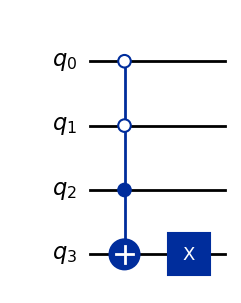

In [41]:
clause_test = {'x0' : True, 'x1' : True, 'x2' : False}

test_qc = QuantumCircuit(4)
disj_gate = logical_disjunction_to_gate(clause_test)
test_qc.append(disj_gate, range(4))
test_qc.decompose().draw('mpl')

# Construire l'oracle

In [42]:
# Créer des registres quantiques pour les variables et les clauses
var_qubits = QuantumRegister(nb_variables, name='x')
clause_qubits = QuantumRegister(nb_clauses, name='c')

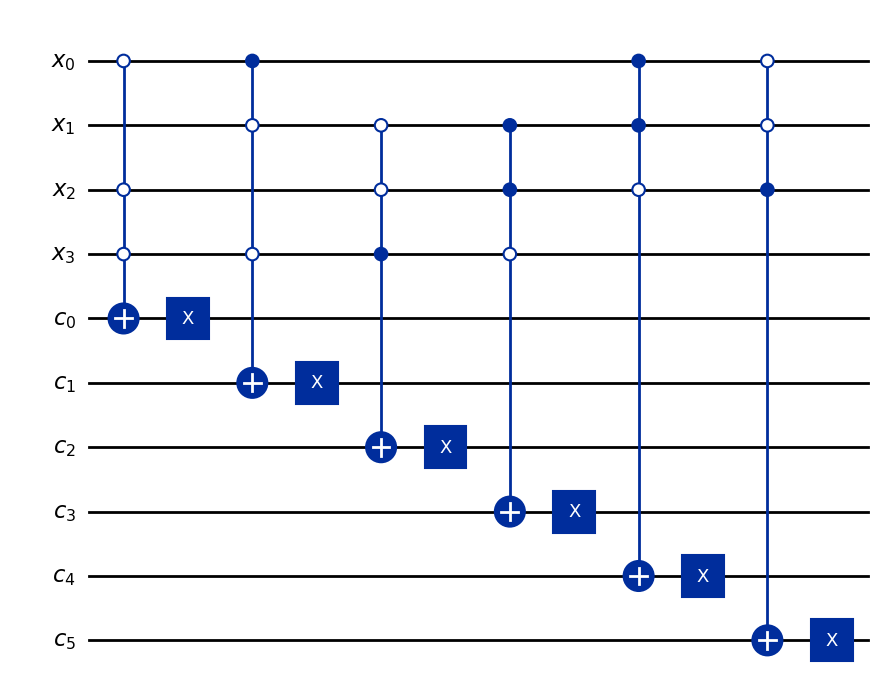

In [43]:
# Construire le circuit de clauses
clauses_circuit = QuantumCircuit(var_qubits, clause_qubits)

# Ajouter chaque clause de disjonction comme une porte en utilisant une boucle
for i in range(nb_clauses):
    # Convertir la disjonction en porte
    gate = logical_disjunction_to_gate(clauses[i])
    # Sélectionner les qubits associés à la clause i
    c_qubits = get_disjunction_qubits(clauses[i], clause_qubits[i], var_qubits)
    # Ajouter la porte au circuit de clauses
    clauses_circuit.append(gate, c_qubits)

# Afficher le circuit : 
clauses_circuit.decompose(gates_to_decompose=['mcx'], reps=2).draw(output='mpl')

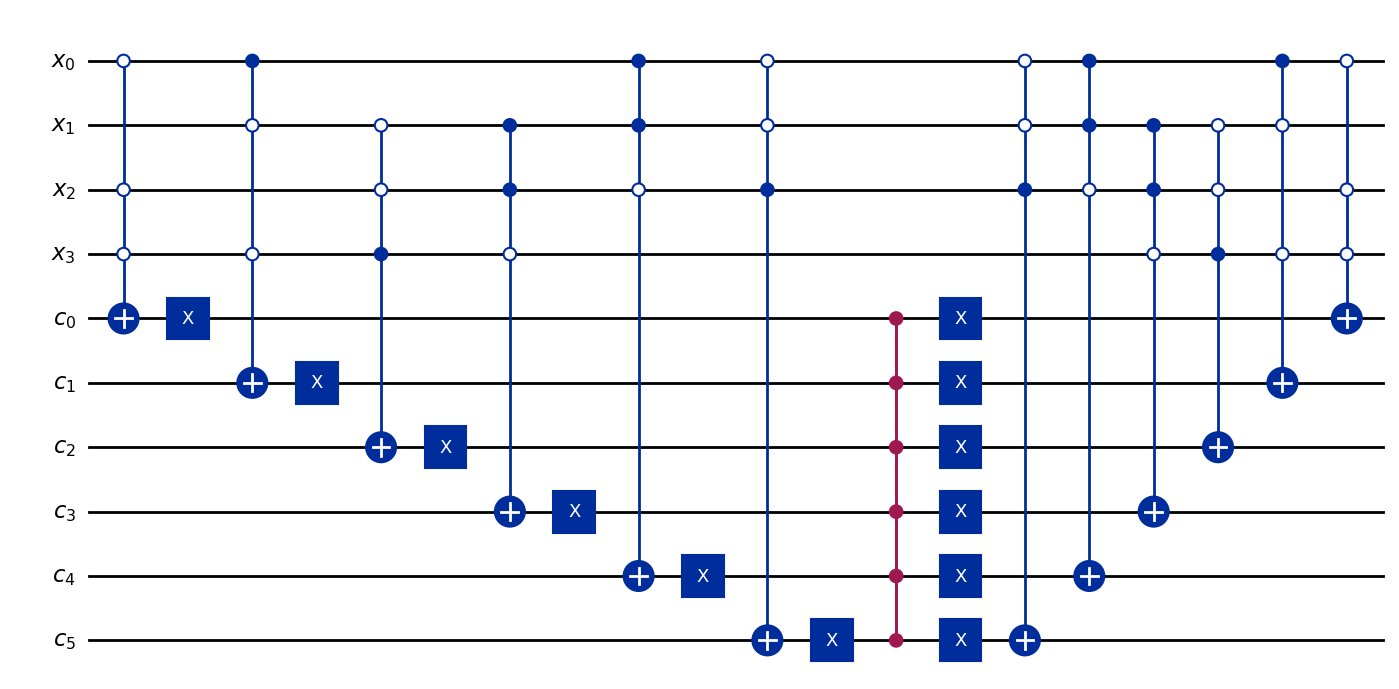

In [44]:
# Construire le circuit de l'oracle
oracle_circuit = QuantumCircuit(var_qubits, clause_qubits)

# Ajouter le circuit de clauses 
# --- la transformation vers une porte n'est utile qu'à des fins d'affichage plus tard ---
oracle_circuit.append(clauses_circuit.to_gate(label='clauses_circuit'), clauses_circuit.qubits)

# Ajouter la porte multi-controle Z
mc_z_gate = ZGate().control(nb_clauses - 1)
oracle_circuit.append(mc_z_gate, clause_qubits)

# Ajouter l'inverse du circuit de clauses
oracle_circuit.append(clauses_circuit.reverse_ops().to_gate(label='clauses_circuit'), oracle_circuit.qubits)

# Afficher le circuit
oracle_circuit.decompose(gates_to_decompose=['clauses_circuit', 'mcx'], reps=2).draw(output='mpl')


# Construire le diffuseur

Complétez le circuit du diffuseur.

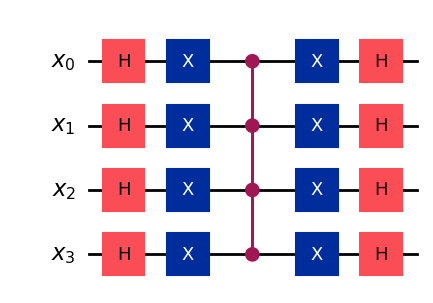

In [45]:
# Construire le circuit de diffuseur
diffuser_circuit = QuantumCircuit(var_qubits)

# Ajouter des portes H et X pour chaque qubit du diffuseur
### 4 portes H pour les variables
diffuser_circuit.h(range(4))

### 4 portes X pour les variables
diffuser_circuit.x(range(4))

# Ajouter une multi-controle Z  
mc_z_gate = ZGate().control(nb_variables - 1)
diffuser_circuit.append(mc_z_gate, var_qubits)

# Ajouter des portes X et H pour chaque qubit du diffuseur
### 4 portes X pour les variables
diffuser_circuit.x(range(4))

### 4 portes H pour les variables
diffuser_circuit.h(range(4))

# Afficher le circuit
diffuser_circuit.draw(output='mpl')

## Explication du diffuseur :

Le diffuseur de Grover effectue l'opération $\hat{U}_{\text{diffuseur}} = 2\ket{s}\langle s| - \hat{I}$, qui amplifie l'amplitude des états marqués. La construction se fait en plusieurs étapes :

1. **Portes H** : Transforment $\ket{s} \rightarrow \ket{\mathbf{0}}$
2. **Portes X** : Transforment $\ket{\mathbf{0}} \rightarrow \ket{\mathbf{1}}$
3. **Multi-contrôle Z** : Inverse la phase de l'état $\ket{\mathbf{1}}$
4. **Portes X** : Retransforment $\ket{\mathbf{1}} \rightarrow \ket{\mathbf{0}}$
5. **Portes H** : Retransforment $\ket{\mathbf{0}} \rightarrow \ket{s}$

Cette séquence réalise une réflexion par rapport à l'état de superposition uniforme $\ket{s}$, ce qui amplifie les amplitudes des états marqués par l'oracle.

# Assembler le circuit de Grover

Complétez le circuit de Grover.

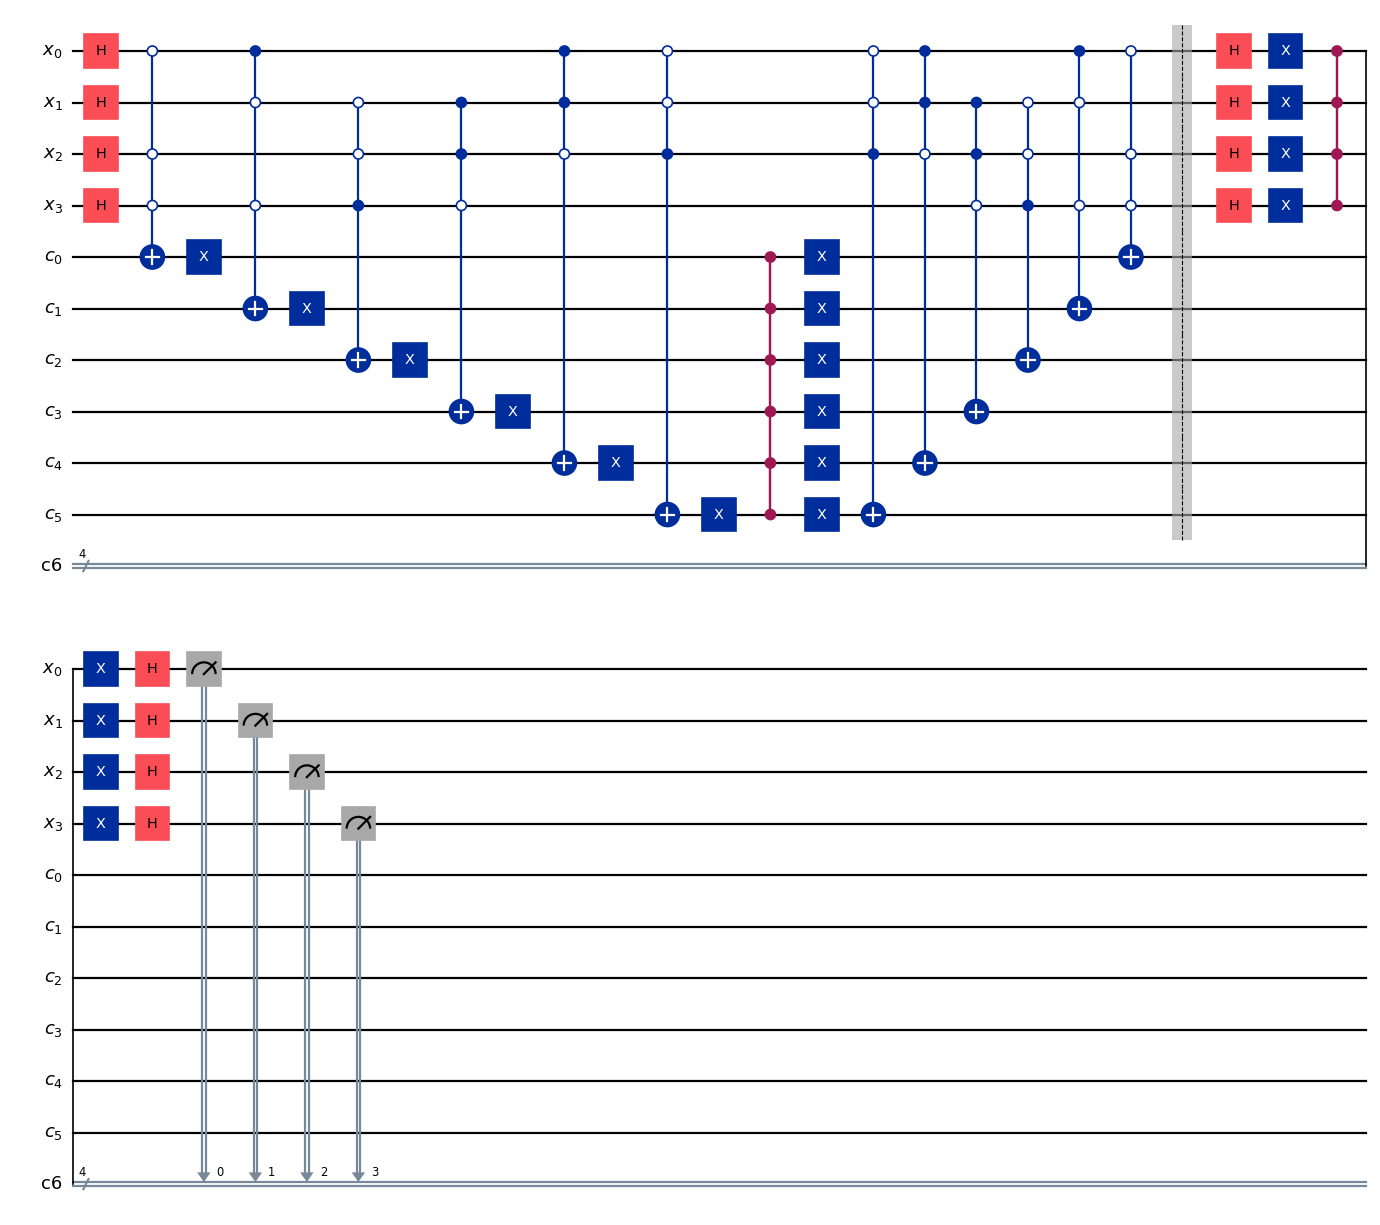

In [46]:
# Construire le circuit de Grover
c_bits = ClassicalRegister(nb_variables)
grover_circuit = QuantumCircuit(var_qubits, clause_qubits, c_bits)

# Ajouter des portes H pour chaque variable
### 4 portes H pour les variables
grover_circuit.h(range(nb_variables))

# Identifier le nombre d'iterations
nb_iterations = 1 # Jouez avec le nombre d'itérations pour en voir l'effet

# Ajouter autant d'oracles et de diffuseurs qu'il y a de nombre d'itérations
for it in range(nb_iterations):
    grover_circuit.append(oracle_circuit.to_gate(label='oracle'), grover_circuit.qubits)
    grover_circuit.barrier(grover_circuit.qubits)
    grover_circuit.append(diffuser_circuit.to_gate(label='diffusor'), grover_circuit.qubits[0:nb_variables])
    
# Ajouter les mesures pour l'evaluation du circuit
grover_circuit.measure(var_qubits, c_bits)

# Afficher le circuit
grover_circuit.decompose(
    gates_to_decompose=['oracle', 'clauses_circuit', 'diffusor', 'mcx'], 
    reps=3).draw(output='mpl', scale=0.8)

## Explication du circuit de Grover complet :

Le circuit de Grover pour ce problème suit cette structure :

1. **Initialisation** : Les portes Hadamard créent l'état de superposition uniforme $\ket{s} = \frac{1}{\sqrt{2^4}} \sum_{\mathbf{x}} \ket{\mathbf{x}}$

2. **Itérations de Grover** : Chaque itération applique :
   - **Oracle** : Marque les solutions en inversant leur phase
   - **Diffuseur** : Amplifie l'amplitude des états marqués

3. **Mesure** : Mesure les qubits de variables pour obtenir la solution

## Note sur le nombre d'itérations optimal :

Pour un système de $n = 4$ qubits avec $N = 2^4 = 16$ états, le nombre optimal d'itérations est approximativement :

$$k_{\text{optimal}} \approx \frac{\pi}{4}\sqrt{N} \approx \frac{\pi}{4}\sqrt{16} \approx 3$$

Vous pouvez essayer `nb_iterations = 3` pour maximiser la probabilité de mesurer la bonne solution au problème de Pincus !


# Mesure de la solution

In [47]:
from qiskit_aer import AerSimulator
from qiskit import transpile

# Prepaper une simulation pour rouler et mesurer la solution
def run_circuit(circ: QuantumCircuit) -> dict:
    """
    Run a quantum circuit on the AerSimulator and return the counts
    @param circ: QuantumCircuit to run
    @return: dictionary of measurement results and their counts
    """
    simulator = AerSimulator()
    circ = transpile(circ, simulator)
    result = simulator.run(circ, shots=1000).result()
    return result.get_counts(circ)

In [48]:

# Executer le circuit et obtenir le compte de solutions
counts = run_circuit(grover_circuit)

print(counts)

{'1101': 224, '1010': 228, '1111': 275, '1110': 273}


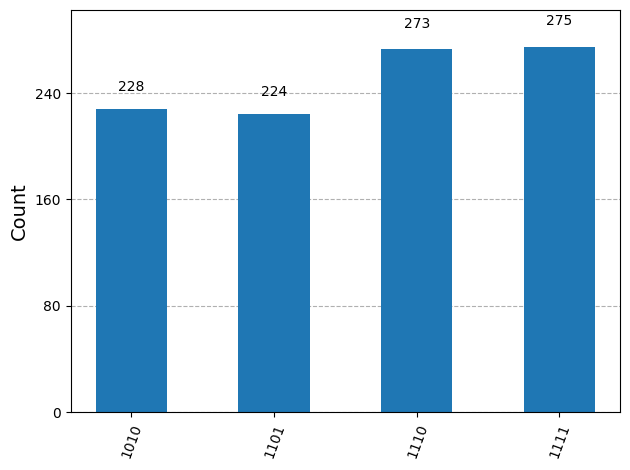

In [49]:
# Afficher l'histogramme de comptes
plot_histogram(counts)

Rappel : 

* x0 = Peureux
* x1 = Heureux
* x2 = Malade
* x3 = Bruyant

Pour interpréter les résultats, il faut comprendre l'ordre des qubits dans la notation de Qiskit.

## Convention de Qiskit (Little Endian)

Qiskit utilise la convention **little endian** (petit-boutiste), où le bit le plus à droite correspond au qubit d'indice le plus bas.

Pour la chaîne `'1011'` :

$$\text{'1011'} = |x_3 x_2 x_1 x_0\rangle$$

Donc :
- **Position 0** (le plus à droite) : $x_0 = 1$
- **Position 1** : $x_1 = 1$
- **Position 2** : $x_2 = 0$
- **Position 3** (le plus à gauche) : $x_3 = 1$

## Interprétation pour le problème de Pincus

Rappel des variables :
- $x_0$ = Peureux (1) / Courageux (0)
- $x_1$ = Heureux (1) / Triste (0)
- $x_2$ = Malade (1) / En santé (0)
- $x_3$ = Bruyant (1) / Discret (0)

Pour `'1011'` : $(x_0, x_1, x_2, x_3) = (1, 1, 0, 1)$

Cela signifie que les habitants sont :
- 😱 **Peureux** ($x_0 = 1$)
- 😃 **Heureux** ($x_1 = 1$)
- 🏥 **En santé** ($x_2 = 0$)
- 🥳 **Bruyant** ($x_3 = 1$)

## États les plus probables

Dans vos résultats, les deux états dominants sont :
- `'1010'` : 172 occurrences → $(x_0, x_1, x_2, x_3) = (0, 1, 0, 1)$ = Courageux, Heureux, En santé, Bruyant
- `'1110'` : 150 occurrences → $(x_0, x_1, x_2, x_3) = (0, 1, 1, 1)$ = Courageux, Heureux, Malade, Bruyant

Ces deux états sont probablement les solutions au problème de Pincus ! Essayez d'augmenter le nombre d'itérations à 3 pour améliorer la probabilité de mesurer ces solutions.